In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import pickle

from IPython import display
%matplotlib inline

from tqdm import tqdm_notebook,tqdm

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [3]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

## data 

In [6]:
y = np.load("../data/simulation/1000_35_like_true/populations_gr.npy")[:, :32, :32]
X = np.load("../data/simulation/1000_35_like_true/amp_gr.npy")[:, :32, :32] 


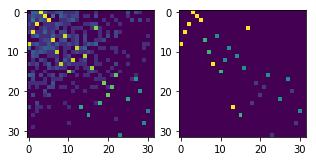

In [7]:
plot_group(X[0], 1, y[0], 0, s = 5)

In [8]:
def normalize(X):
    sums = X.sum(1)
    sums[sums == 0] = 1
    D = np.diag(1 / np.sqrt(sums))
    
    return np.dot(np.dot(D, X), D)

In [215]:
def normalize_arr(X, normalizer):
    X_n = np.zeros_like(X)
    for i, x in enumerate(X):
        X_n[i] = normalizer(x)
    return X_n

In [10]:
def create_powers(X, max_power=5):
    X_p = np.zeros((X.shape[0], max_power, X.shape[1], X.shape[2]))
    for i, x in enumerate(X):
        X_p[i, 0] = x
        for p in range(2, max_power + 1):
            X_p[i, p - 1] = np.dot(X_p[i, p - 2], x)
            
    return X_p

In [11]:
X_n = normalize_arr(X)

X_p = create_powers(X)
X_p_n = create_powers(X_n)

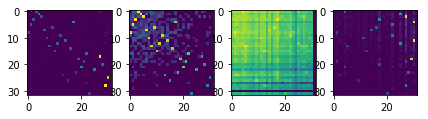

In [12]:
plot_group(normalize(X[0]), 0, X[0], 1, X_p[0, 4], 1, X_p_n[0, 4], 1)

In [216]:
X_p_n = create_powers(normalize_arr(X, normalize))
X_p_l = create_powers(normalize_arr(X, normalize_left))
X_p_r = create_powers(normalize_arr(X, normalize_right))

In [13]:
defaul_x = np.diag(np.ones(32))

## Net

In [71]:
from keras.layers import Dense, Embedding

In [72]:
class GraphConvLayer:
    
    def __init__(self, name, window, size):
        self.name = name
        self.window = window
        self.size = size
        
        with tf.variable_scope(name) as scope:
            self.g = tf.get_variable('g',
                                    shape = [size, window],
                                    initializer=None, trainable=True)
            
            self.b = tf.get_variable('b' , shape = [size], initializer=None, trainable=True) 
        self.scope = scope
        
    def __call__(self, inp, a_powers):
        #assert a_powers.shape[0] == self.window
        
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                tm = tf.tensordot(a_powers[:self.window], inp, axes = [[2], [0]])
                tm_sum = tf.reduce_sum(tm, 2)

                out = tf.tensordot(tm_sum, self.g, axes=[[0],[1]]) + self.b
                
        return out                

In [194]:
X_p_n.shape

(1000, 5, 32, 32)

In [196]:
np.transpose(X_p_n, [0,1,3,2])

(1000, 5, 32, 32)

In [257]:
X_p_n_p = np.concatenate((X_p_n, X_p_l, X_p_r, np.transpose(X_p_n, [0,1,3,2]), np.transpose(X_p_l, [0,1,3,2]), np.transpose(X_p_r, [0,1,3,2])), 1)

In [258]:
X_p_n_p.shape

(1000, 30, 32, 32)

In [270]:
tf.reset_default_graph()
sess = tf.Session()

In [271]:
upper = np.triu(np.ones((32,32)))
lower = np.ones((32,32)) - upper

In [272]:
inp = tf.placeholder(tf.float32, [32, 32])
a_powers = tf.placeholder(tf.float32, [None, 32, 32])

c1_l = GraphConvLayer('c1', 30, 32)
c1 = c1_l(inp, a_powers)
c1 = tf.nn.relu6(c1)

c12_l = GraphConvLayer('c1_2', 30, 32)
c12 = c12_l(c1, a_powers)
c12 = tf.nn.relu6(c12)

c2_l = GraphConvLayer('c2', 30, 32)
c2 = c2_l(inp, a_powers)
c2 = tf.nn.tanh(c2)

c22_l = GraphConvLayer('c2_2', 30, 32)
c22 = c22_l(c2, a_powers)
c22 = tf.nn.relu6(c22)

# out_logit = tf.matmul(c2[:,:16], tf.transpose(c2[:, :16])) * upper + \
#             tf.matmul(c2[:,16:], tf.transpose(c2[:, 16:])) * lower 

# c3_l = GraphConvLayer('c3', 3, 32)
# c3 = c3_l(c2, a_powers)
# c3 = tf.nn.relu(c3)

# c4_l = GraphConvLayer('c4', 3, 32)
# c4 = c4_l(c3, a_powers)
# c4 = tf.nn.relu(c4)


#I = tf.get_variable('i', shape = [32,32])
#O = tf.get_variable('o', shape = [32,32])

#out_logit = tf.matmul(tf.matmul(c2, I), tf.transpose(c2))# * upper + \
            #tf.matmul(tf.matmul(c2, O), tf.transpose(c2)) * lower 

# b_i = tf.get_variable('ib', shape = [32])
# b_o = tf.get_variable('ob', shape = [32])

# ID = Dense(32, activation=tf.nn.relu6)(c2)
# OD = Dense(32, activation=tf.nn.relu6)(c2)

# ID2 = Dense(32, activation=tf.nn.relu6)(ID)
# OD2 = Dense(32, activation=tf.nn.relu6)(OD)

# #out_logit = tf.matmul(tf.matmul(c3, I) + b_i, tf.transpose(tf.matmul(c3, O)) + b_o)
# out_logit = tf.matmul(ID, tf.transpose(OD))

out_logit = tf.matmul(c1, tf.transpose(c2))
#out = tf.nn.sigmoid(out_logit)

In [273]:
out = tf.nn.sigmoid(out_logit)

In [274]:
target = tf.placeholder(tf.float32, [None, None])
weights = tf.placeholder(tf.float32, [None, None])

In [275]:
loss = tf.losses.log_loss(out, target, weights = weights)

In [276]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)

In [277]:
sess.run(tf.global_variables_initializer())

In [278]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("./tf_logs", gr)

In [279]:
train_loss = []
val_scores = []
val_loss = []

epochs = 500
l_r = 0.001

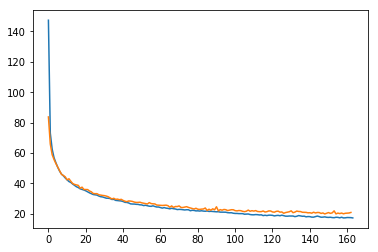

A Jupyter Widget

A Jupyter Widget

KeyboardInterrupt: 

In [316]:
for epoch in range(epochs):
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm_notebook(enumerate(zip(X_p_n_p[:800], y[:800]))):
        batch_w = (batch_y > 0.).astype(float) * (batch_y == 0).sum() + (batch_y == 0).astype(float) * (batch_y != 0).sum()
        #batch_w = (batch_y > 0.).astype(float) * (batch_y == 0).sum()  + (batch_y == 0).astype(float) * (batch_y != 0).sum()
        batch_loss = sess.run([train_step,loss], feed_dict={inp : defaul_x,
                                                            a_powers : batch_x,
                                                            target: (batch_y > 0).astype(float),
                                                            weights : batch_w})

        curr_loss += batch_loss[1]
        #print(curr_loss)

    train_loss.append(curr_loss / (i + 1)) 

    
    
    curr_loss = 0
    for i, (batch_x, batch_y) in tqdm_notebook(enumerate(zip(X_p_n_p[800:], y[800:]))):
        batch_w = (batch_y > 0.).astype(float) * (batch_y == 0).sum() + (batch_y == 0).astype(float) * (batch_y != 0).sum()
        #batch_w = np.ones_like(batch_y)
        batch_loss = sess.run([loss], feed_dict={inp : defaul_x,
                                                 a_powers : batch_x,
                                                 target: (batch_y > 0).astype(float),
                                                 weights : batch_w})
        curr_loss += batch_loss[0]
        #print(curr_loss)

    val_loss.append(curr_loss / (i + 1))
    
    
    #val_loss.append(sess.run(loss, feed_dict={x:X_n, target:val_y, loss_mask:val_mask}))
   
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    #plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')

    plt.show()
            

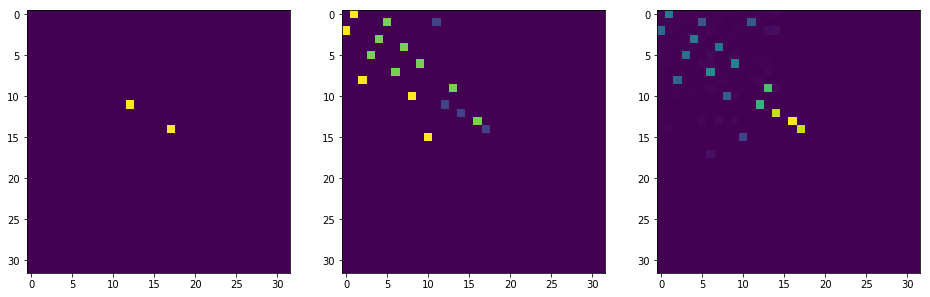

In [321]:
ind = 1
pred = sess.run(out, feed_dict={inp : defaul_x, a_powers : X_p_n_p[ind]})
plot_group(pred == 1, 0, y[ind], 0, X_n[ind], 0, s = 16)

In [299]:
#pred_embs, pred_embs_I, pred_embs_O = sess.run([c2, ID, OD], feed_dict={inp : defaul_x, a_powers : X_p_n_p[ind]})
pred_embs = sess.run(c2, feed_dict={inp : defaul_x, a_powers : X_p_n_p[ind]})

from sklearn.decomposition import PCA
pca = PCA(32)

pred_embs_PCA = pca.fit_transform(pred_embs[:])

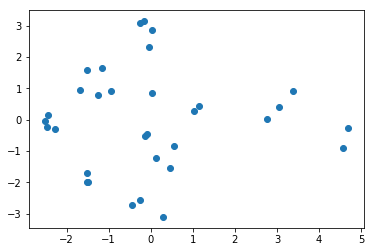

In [300]:
plt.scatter(pred_embs_PCA[:,0], pred_embs_PCA[:, 1])

In [314]:
batch_w.max()

995.0

In [315]:
batch_w.min()

29.0

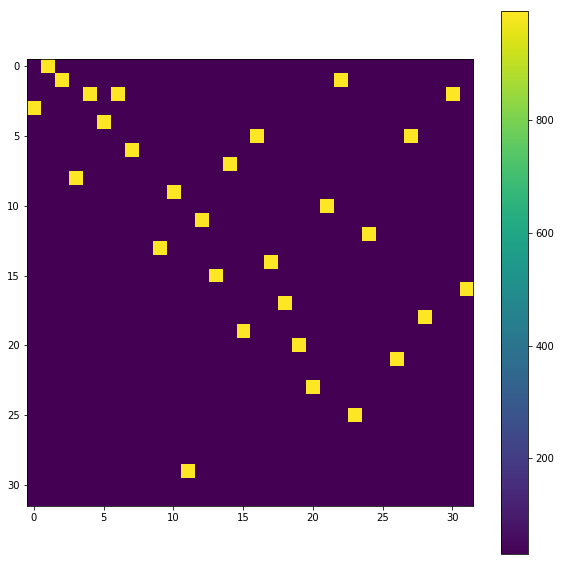

In [313]:
plot_gr(batch_w)

In [24]:
upper

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

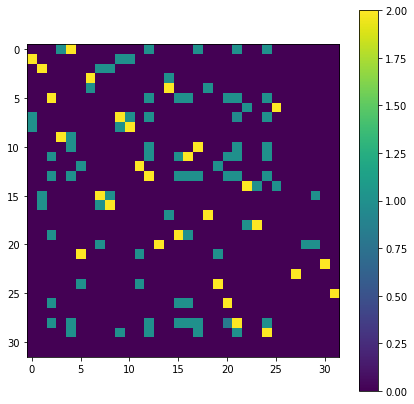

In [439]:
plot_gr(pred + (y[ind] > 0).astype(int), s = 7)

In [92]:
es = np.load("../data/graphs/ES3_22.npy")[:32, :32]

In [93]:
es_p_n = create_powers(np.expand_dims(normalize(es), 0), 5)[0]

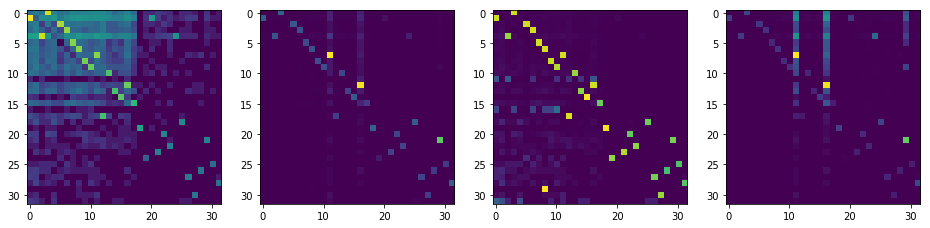

In [328]:
plot_group(es, 1, normalize(es), 1, normalize_left(es), 1, normalize_right(es), 1, s = 16)

In [310]:
preds = np.zeros((200, 32,32))

for i in range(800,1000):
    preds[i - 800] = sess.run(out, feed_dict={inp : defaul_x, a_powers : X_p_n_p[i]})

In [311]:
from sklearn.metrics import classification_report

In [312]:
print(classification_report((y[800:] > 0).astype(int).flatten(), preds.flatten().astype(int)))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    199514
          1       0.84      0.18      0.30      5286

avg / total       0.98      0.98      0.97    204800



In [417]:
print(classification_report((y[800:] > 0).astype(int).flatten(), preds.flatten().astype(int)))

             precision    recall  f1-score   support

          0       1.00      0.95      0.97    199514
          1       0.32      0.90      0.48      5286

avg / total       0.98      0.95      0.96    204800



In [468]:
print(classification_report((y[800:] > 0).astype(int).flatten(), preds.flatten().astype(int)))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97    199514
          1       0.26      0.83      0.40      5286

avg / total       0.98      0.93      0.95    204800



In [8]:
def normalize(X):
    sums = X.sum(1)
    sums[sums == 0] = 1
    D = np.diag(1 / np.sqrt(sums))
    
    return np.dot(np.dot(D, X), D)

In [125]:
def normalize_left(X):
    sums = X.sum(1)
    sums[sums == 0] = 1
    D = np.diag(1 / sums)
    
    return np.dot(D, X)

In [126]:
def normalize_right(X):
    sums = X.sum(1)
    sums[sums == 0] = 1
    D = np.diag(1 / sums)
    
    return np.dot(X, D)

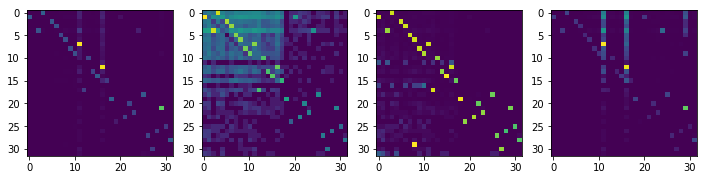

In [129]:
plot_group(es_p_n[0], 1, es, 1, normalize_left(es), 1, normalize_right(es), 1, s = 12)